In [1]:
# Импортируем библиотеки для работы.
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# LowerBound отвечает за поиск элемента, который больше либо равен значению key в массиве A.
def LowerBound(arr, key):
    left = -1
    right = len(arr)

    while right > left + 1:
        middle = (left + right) // 2
        if arr[middle][1] >= key:
            right = middle
        else:
            left = middle

    return right

In [3]:
# # Поиск следующего шара в цепочке столкновений.
# def FNB(x, y, arr, r):
#     eps = 1e-8
#     minn = 1e+9
#     pos = -1
#     for i in range(LowerBound(arr, y - 2 * r + eps), len(arr)):
#         if arr[i][1] > y + 2 * r - eps:
#             break
#         elif x + eps < arr[i][0] < minn - eps:
#             minn = arr[i][0]
#             pos = i
#     return pos

# Поиск следующего шара в цепочке столкновений.
# Уточняем границы через grnz -> (grnz + l_box) % l_box.
# Два варианта поиска ближайшего - в лоб (+) и умный через идею о половине круга.
def FNB(x, y, arr, r):
    eps = 1e-8
    minn = 1e+12
    pos = -1

    # Будет три случая - зона поиска в рамках коробки, зона поиска выходит снизу, зона поиска выходит сверху.
    # Можно выделить особый случай - когда рамки поиска будут выходить за границы, но засчет разделения ситуаций if-ами, а не elif-ами, эта проблема невелируется.
    # Пока предположим, что такой ситуации быть не может.

    # 1 случай. Зона поиска внутри коробки.
    if y - 2 * r + eps >= 0 and y + 2 * r - eps <= l_box:

        for i in range(LowerBound(arr, y - 2 * r + eps), len(arr)):

            if arr[i][1] > y + 2 * r + eps:
                break

            elif x + eps < arr[i][0] and CCB(x, y, arr[i][0], arr[i][1], r)[1] < minn - eps:
                minn = CCB(x, y, arr[i][0], arr[i][1], r)[1]
                pos = i

    # 2 случай, зона поиска выходит снизу.
    elif y - 2 * r + eps < 0:

        # Поиск в стандартном пространстве.
        for i in range(LowerBound(arr, y - 2 * r + eps), len(arr)):

            if arr[i][1] > y + 2 * r + eps:
                break

            elif x + eps < arr[i][0] and CCB(x, y, arr[i][0], arr[i][1], r)[1] < minn - eps:
                minn = CCB(x, y, arr[i][0], arr[i][1], r)[1]
                pos = i

        # Поиск в сдвинутом пространстве.
        x_tmp, y_tmp = x + l_box, y

        for i in range(LowerBound(arr, y - 2 * r + l_box + eps), len(arr)):
            # Тут мы просто пробегаем доверху, то есть до конца массива.

            if  x_tmp + eps < arr[i][0] and CCB(x_tmp, y_tmp, arr[i][0], arr[i][1], r)[1] < minn - eps:
                minn = CCB(x_tmp, y_tmp, arr[i][0], arr[i][1], r)[1]
                pos = i

    # 3 случай, зона выходит сверху.
    elif y + 2 * r - eps > l_box:

        # Поиск в стандартном пространстве.
        for i in range(LowerBound(arr, y - 2 * r + eps), len(arr)):

            if arr[i][1] > y + 2 * r + eps:
                break

            elif x + eps < arr[i][0] and CCB(x, y, arr[i][0], arr[i][1], r)[1] < minn - eps:
                minn = CCB(x, y, arr[i][0], arr[i][1], r)[1]
                pos = i

        # Поиск в сдвинутом пространстве.
        x_tmp, y_tmp = x - l_box, y
        # for i in range(0, LowerBound(arr, y + 2 * r - l_box + eps)):

        for i in range(0, len(arr)):

            # Тут работая с уровнем внутри коробки, лучше будем проверять if-ом высоту.
            if arr[i][1] > y + 2 * r - l_box + eps:
                break

            # Тут мы пробегаем до линии уровня.
            elif  x_tmp + eps < arr[i][0] and CCB(x_tmp, y_tmp, arr[i][0], arr[i][1], r)[1] < minn - eps:
                minn = CCB(x_tmp, y_tmp, arr[i][0], arr[i][1], r)[1]
                pos = i
    return pos

In [4]:
# Вычисление новой позиции шара при движении.
def CCB(x1, y1, x2, y2, r):
    x_new = -(((2 * r) ** 2 - (y1 - y2) ** 2) ** (1 / 2)) + x2
    l_pr = x_new - x1
    return [x_new, l_pr]

In [5]:
# Моделирование движения шаров параллельно оси x.
def MOB_x(ind_sh, arr, r, l_ost, l_box):
    # Перед началом работы отсортируем массив.
    arr = arr[np.argsort(arr[:, 1])]

    # Прежде всего, необходимо понять, находится ли шар в буферной зоне или нет.
    eps = 1e-8
    x = arr[ind_sh][0]
    y = arr[ind_sh][1]

    if x < l_box - r - eps:
        # Мы находимся внутри коробки.
        pos = FNB(x, y, arr, r)

        if pos == -1:
            # Значит шаров, с которыми можно столкнуться внутри коробки нет.
            if l_ost > (l_box - r) - x + eps:
                l_ost -= (l_box - r) - x
                arr[ind_sh][0] = l_box - r
                #print(l_ost, 1)
                return MOB_x(ind_sh, arr, r, l_ost, l_box)
            else:
                arr[ind_sh][0] += l_ost
                return arr

        else:
            # Значит есть шар, с которым можно столкнуться.
            x_new, l_pr = CCB(x, y, arr[pos][0], arr[pos][1], r)
            #print(x, y, arr[pos][0], arr[pos][1])
            if l_ost > l_pr + eps:
                l_ost -= l_pr
                arr[ind_sh][0] += l_pr
                #print(l_ost, l_pr, 2)
                #print()
                return MOB_x(pos, arr, r, l_ost, l_box)
            else:
                arr[ind_sh][0] += l_ost
                return arr

    else:
        # Мы находимся внутри буферной зоны или на ее границе.
        # Важным уточнением является то, что мы ввели буферную зону, но не заполняли ее. Поэтому важна отдельная обработка поиска шаров для начала коробки, так как в начальный момент, например, в буфере ничего нет, но вот в процессе шар может появиться, это необходимо учитывать.
        pos_buf = FNB(x, y, arr, r)
        pos_strt = FNB(x - l_box, y, arr, r)

        # Для начала проверим, есть ли шары, с которыми мы можем столкнуться в буферной зоне.
        if pos_buf != -1:
            # Таким образом, есть шар, с которым мы столкнемся в буферной зоне.
            pos = pos_buf
            x_new, l_pr = CCB(x, y, arr[pos][0], arr[pos][1], r)
            if l_ost > l_pr + eps:
                l_ost -= l_pr
                arr[ind_sh][0] += l_pr
                #print(l_ost, 3)
                return MOB_x(pos, arr, r, l_ost, l_box)
            else:
                arr[ind_sh][0] += l_ost
                return arr

        else:
            # То есть буферная полоса пустая. По крайней мере, если "смотреть" с конца, давайте рассмотрим ситуацию от левого края коробки (левой буферной зоны).
            if pos_strt != -1 and np.array_equal(arr[pos_strt], np.array(x, y)) == False:
                # Значит мы нашли шар, с которым мы столкнемся, причем он лежит внутри коробки, иначе мы бы нашли его при просмотре буферной зоны.
                # Здесь необходимо работать аккуратно и, в случае если шар прошел буферную зону, перевести его в обычную зону.
                pos = pos_strt
                x_new, l_pr = CCB(x - l_box, y, arr[pos][0], arr[pos][1], r)
                if l_ost > l_pr + eps:
                    l_ost -= l_pr
                    arr[ind_sh][0] += l_pr
                    if arr[ind_sh][0] > (l_box + r) - eps:
                        arr[ind_sh][0] -= (l_box + r)
                    #print(l_ost, 4)
                    return MOB_x(pos, arr, r, l_ost, l_box)
                else:
                    arr[ind_sh][0] += l_ost
                    if arr[ind_sh][0] > (l_box + r) - eps:
                        arr[ind_sh][0] -= (l_box + r)
                    return arr

            else:
                # Значит шаров для столкновения, тогда двигаем настолько, насколько можем.
                arr[ind_sh][0] += l_ost
                if arr[ind_sh][0] >= (l_box + r) - eps:
                    arr[ind_sh][0] -= (l_box + r)
                return arr

In [6]:
# Моделирование движения шаров параллельно оси y.
def MOB_y(ind_sh, arr, r, l_ost, l_box):
    # Разворачиваем массив.
    for i in range(len(arr)):
        arr[i] = np.array([arr[i][1], arr[i][0]])

    # Передаем в функцию движения.
    arr_y = MOB_x(ind_sh, arr, r, l_ost, l_box)

    # Разворачиваем массив.
    for i in range(len(arr_y)):
        arr_y[i] = np.array([arr_y[i][1], arr_y[i][0]])

    # Возвращаем результат.
    return arr_y

In [7]:
# Сохранение графика как картинки.
def SP(arr, l_box, r, ind):

    a = arr
    name = "Shar" + str(ind) + ".png"
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set(xlim=(0, l_box), ylim=(0, l_box))

    for i in range(len(a)):
        a[i][0], a[i][1] = (a[i][0] + l_box) % l_box, (a[i][1] + l_box) % l_box
        if a[i][0] < r and a[i][1] > l_box - r:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle((a[i][0], (a[i][1] % (l_box - r)) - r), r, color='r')
            circle3 = plt.Circle((a[i][0] + l_box, a[i][1]), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)
            ax.add_patch(circle3)

        elif r < a[i][0] < l_box - r and a[i][1] > l_box - r:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle((a[i][0], (a[i][1] % (l_box - r)) - r), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)

        elif l_box - r < a[i][0] and l_box - r < a[i][1]:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle((a[i][0], (a[i][1] % (l_box - r)) - r), r, color='r')
            circle3 = plt.Circle(((a[i][0] % (l_box - r)) - r, a[i][1]), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)
            ax.add_patch(circle3)

        elif a[i][0] < r and r < a[i][1] < l_box - r:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle((a[i][0] + l_box, a[i][1]), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)

        elif l_box - r < a[i][0] and r < a[i][1] < l_box - r:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle(((a[i][0] % (l_box - r)) - r, a[i][1]), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)

        elif a[i][0] < r and a[i][1] < r:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle((a[i][0] + l_box, a[i][1]), r, color='r')
            circle3 = plt.Circle((a[i][0], a[i][1] + l_box), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)
            ax.add_patch(circle3)

        elif r < a[i][0] < l_box - r and a[i][1] < r:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle((a[i][0], a[i][1] + l_box), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)

        elif l_box - r < a[i][0] and a[i][1] < r:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
            circle2 = plt.Circle(((a[i][0] % (l_box - r)) - r, a[i][1]), r, color='r')
            circle3 = plt.Circle((a[i][0], a[i][1] + l_box), r, color='r')
            ax.add_patch(circle1)
            ax.add_patch(circle2)
            ax.add_patch(circle3)
        else:
            circle1 = plt.Circle((a[i][0], a[i][1]), r, color='b')
            ax.add_patch(circle1)
        ax.set_aspect('equal')

    fig.savefig(name)

Основная часть кода:

In [8]:
# Генерируем упаковку шаров, для r = 1:
l_box = 38
mas = np.array([]).reshape(0,2)

for i in range(1, l_box, 3):
    for j in range(1, l_box, 3):
        mas = np.append(mas, [[j, i]], axis = 0)

for i in range(2, l_box, 3):
    for j in range(2, l_box, 3):
        mas = np.append(mas, [[j + 0.5, i + 0.5]], axis = 0)

C:\Users\ender\AppData\Local\Temp\ipykernel_11700\1492863809.py:3: RuntimeWarning: invalid value encountered in double_scalars
  x_new = -(((2 * r) ** 2 - (y1 - y2) ** 2) ** (1 / 2)) + x2


CPU times: total: 969 ms
Wall time: 2.19 s


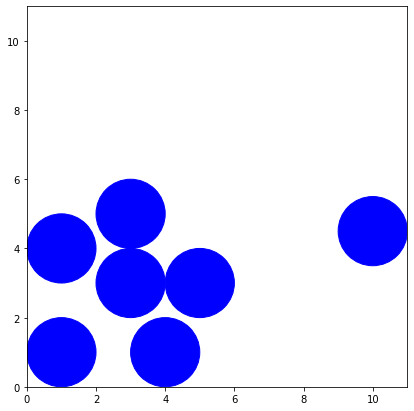

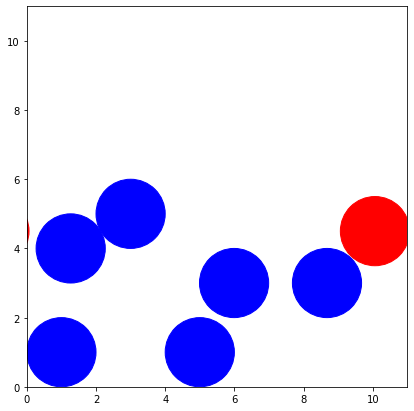

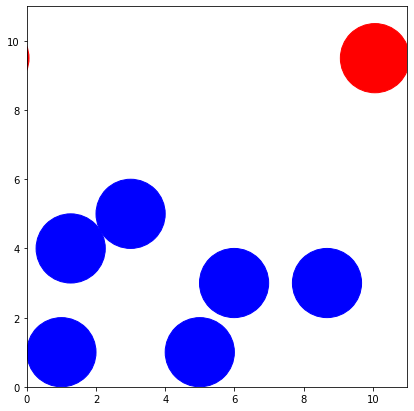

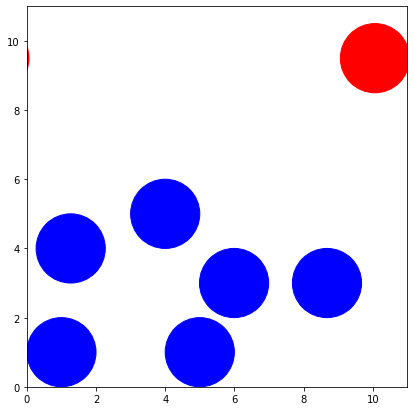

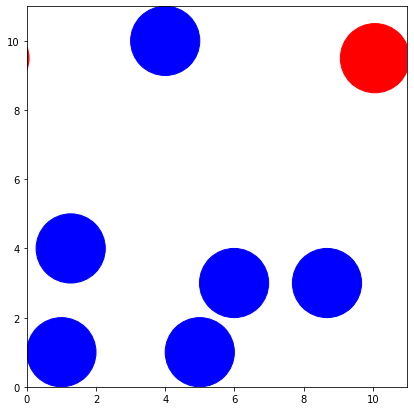

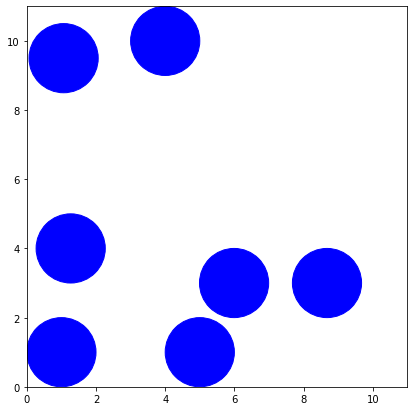

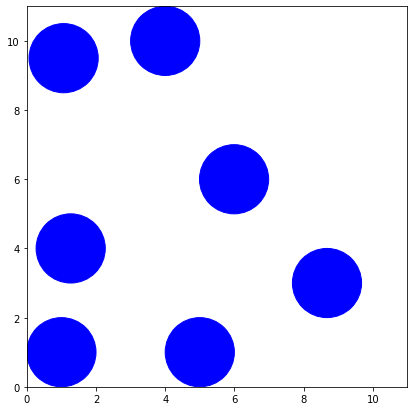

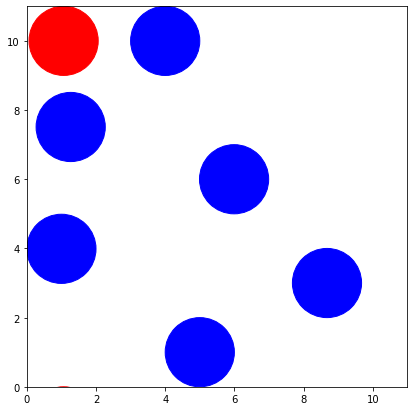

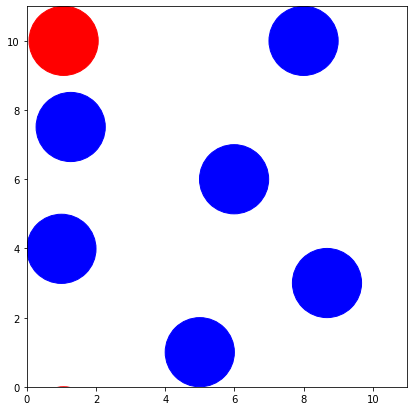

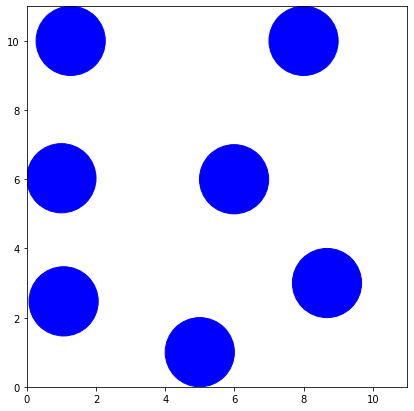

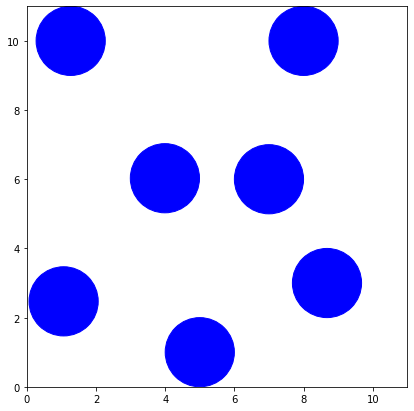

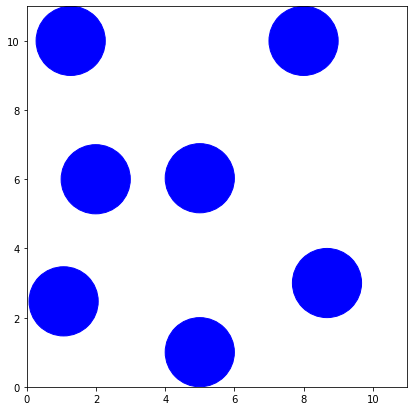

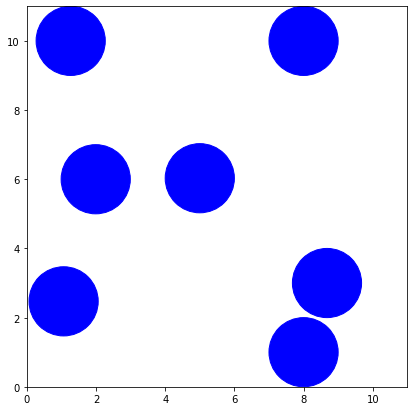

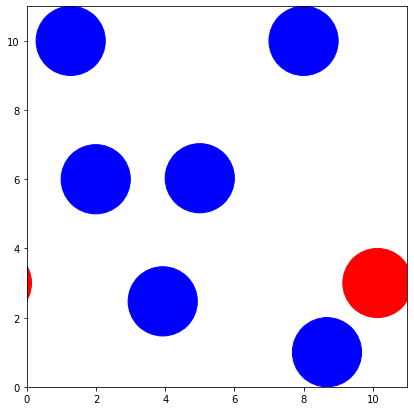

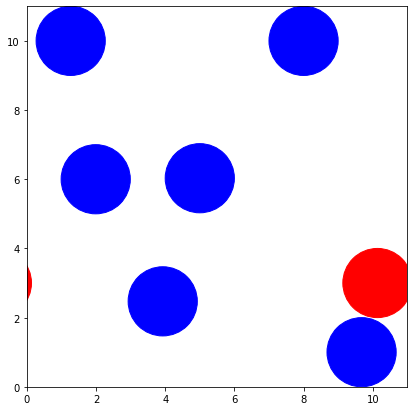

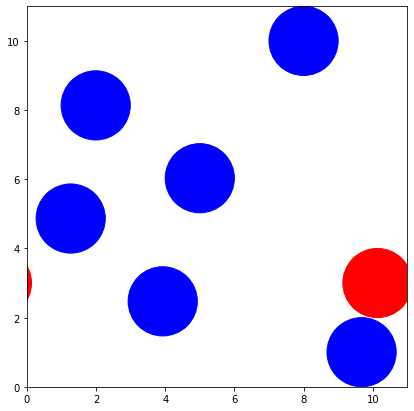

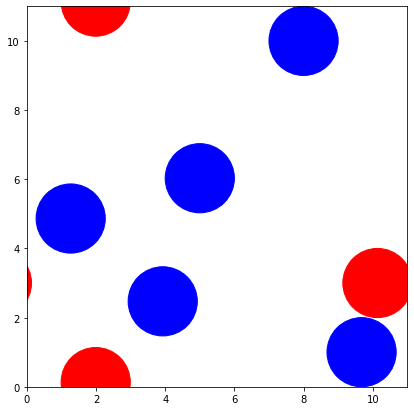

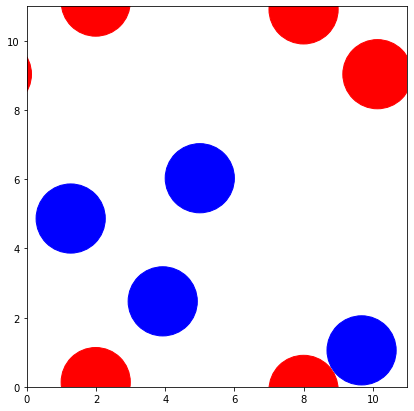

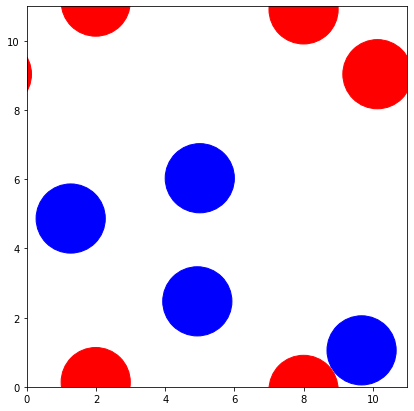

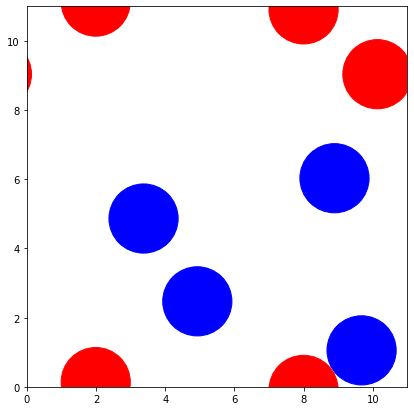

In [9]:
%%time
# Выписываем ключевые переменные.
r = 1
l_box = 11
tmp = mas
frames = []

a = np.array([[1,1], [4,1], [10, 2.5], [3,3], [5,3], [1,4], [3,5]])
a = a[np.argsort(a[:, 1])]
tmp = a

# Переходим в папку с результатами.
os.chdir("Results")

# После чего начинаем моделировать столкновения по случайным осям и расстояниям.
for i in range(20):
    seed = np.random.randint(2)
    l_ost = np.random.randint(1, l_box)

    if seed == 0:
        shx = np.random.randint(len(tmp))
        tmp = MOB_x(shx, tmp, r, l_ost, l_box)

    if seed == 1:
        shy = np.random.randint(len(tmp))
        tmp = MOB_y(shy, tmp, r, l_ost, l_box)
    SP(tmp, l_box, r, i)

# Список для хранения кадров.
frames = []
LoF = os.listdir()

for frame_number in range(len(LoF)):
    frame = Image.open(LoF[frame_number])
    frames.append(frame)

frames[0].save(
    'colission.gif',
    save_all=True,
    append_images=frames[1:],  # Срез который игнорирует первый кадр.
    optimize=True,
    duration=1500,
    loop=0
)

# Не забываем вернуться в исходную папку.
os.chdir("..")

res = tmp

In [113]:
os.chdir("..")
os.getcwd()

'C:\\Users\\ender\\Desktop\\Наука\\Работа и научная деятельность\\temp'

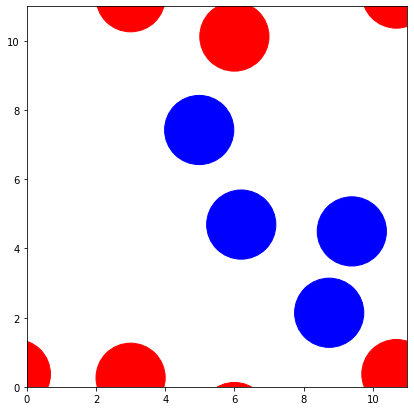

In [78]:
# Отрисовка результата.
%matplotlib inline

l_box = 11
r = 1

# a = np.array([[1,1], [4,1], [10, 2.5], [3,3], [5,3], [1,4], [3,5]])
# a = a[np.argsort(a[:, 1])]
a = tmp
fig, ax = plt.subplots(figsize=(7,7))

ax.set(xlim=(0, l_box), ylim=(0, l_box))

for i in range(len(a)):
    a[i][0], a[i][1] = (a[i][0] + l_box) % l_box, (a[i][1] + l_box) % l_box
    if a[i][0] < r and a[i][1] > l_box - r:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle((a[i][0], (a[i][1] % (l_box - r)) - r), r, color='r')
        circle3 = plt.Circle((a[i][0] + l_box, a[i][1]), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(circle3)

    elif r < a[i][0] < l_box - r and a[i][1] > l_box - r:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle((a[i][0], (a[i][1] % (l_box - r)) - r), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)

    elif l_box - r < a[i][0] and l_box - r < a[i][1]:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle((a[i][0], (a[i][1] % (l_box - r)) - r), r, color='r')
        circle3 = plt.Circle(((a[i][0] % (l_box - r)) - r, a[i][1]), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(circle3)

    elif a[i][0] < r and r < a[i][1] < l_box - r:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle((a[i][0] + l_box, a[i][1]), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)

    elif l_box - r < a[i][0] and r < a[i][1] < l_box - r:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle(((a[i][0] % (l_box - r)) - r, a[i][1]), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)

    elif a[i][0] < r and a[i][1] < r:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle((a[i][0] + l_box, a[i][1]), r, color='r')
        circle3 = plt.Circle((a[i][0], a[i][1] + l_box), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(circle3)

    elif r < a[i][0] < l_box - r and a[i][1] < r:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle((a[i][0], a[i][1] + l_box), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)

    elif l_box - r < a[i][0] and a[i][1] < r:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='r')
        circle2 = plt.Circle(((a[i][0] % (l_box - r)) - r, a[i][1]), r, color='r')
        circle3 = plt.Circle((a[i][0], a[i][1] + l_box), r, color='r')
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(circle3)
    else:
        circle1 = plt.Circle((a[i][0], a[i][1]), r, color='b')
        ax.add_patch(circle1)
ax.set_aspect('equal')

In [ ]:
import python2pseudocode
python2pseudocode.python_to_pseudocode()